In [1]:
#import os
#import cv2
import skimage.io
from tqdm.notebook import tqdm
#import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image 


import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

# EDA

In [2]:
from pathlib import Path
PATH = Path("../data")

In [3]:
labels = pd.read_csv(PATH/'train_labels.csv')
labels.head(3)
test = pd.read_csv(PATH/'test.csv')

In [4]:
# path2 = Path('../data/train')
# files = [str(p) for p in path2.iterdir()]

# to_concat= []
# for i,row in labels.iterrows():
#     full_file = '../data/train/' + row['image_id'] + '_0.png'
#     if full_file in files:
#         to_concat.append(pd.DataFrame(row))

# labels = pd.concat(to_concat, axis=0)


In [5]:
# labels = pd.concat([tc.T for tc in to_concat])

In [6]:
# labels.loc[labels['image_id'] == 'ffe9bcababc858e04840669e788065a1']

In [7]:
# labels.to_csv(PATH/'train_labels_clean.csv', index=False)

In [8]:
labels = pd.read_csv(PATH/'train_labels_clean.csv')

In [9]:
example = ['ffe9bcababc858e04840669e788065a1_0.png', 
           'ffe9bcababc858e04840669e788065a1_1.png',
           'ffe9bcababc858e04840669e788065a1_10.png', 
           'ffe9bcababc858e04840669e788065a1_11.png',
            'ffe9bcababc858e04840669e788065a1_12.png',
            'ffe9bcababc858e04840669e788065a1_13.png',
            'ffe9bcababc858e04840669e788065a1_13.png',
            'ffe9bcababc858e04840669e788065a1_14.png',
            'ffe9bcababc858e04840669e788065a1_15.png',
            'ffe9bcababc858e04840669e788065a1_2.png',
            'ffe9bcababc858e04840669e788065a1_3.png',
            'ffe9bcababc858e04840669e788065a1_4.png',
            'ffe9bcababc858e04840669e788065a1_5.png',
            'ffe9bcababc858e04840669e788065a1_6.png',
            'ffe9bcababc858e04840669e788065a1_7.png',
            'ffe9bcababc858e04840669e788065a1_8.png',
            'ffe9bcababc858e04840669e788065a1_9.png']

In [10]:
def read_file(filename):
    '''return array representing image'''
    return skimage.io.imread(PATH/f'train/{filename}')

In [11]:
def read_file_bw(filename):
    image_file = Image.open(PATH/f'train/{filename}') # open colour image
    image_file = image_file.convert('1') # convert image to black and white
    return image_file

In [12]:
def read_mask(filename):
    return skimage.io.imread(PATH/f'masks/{filename}')

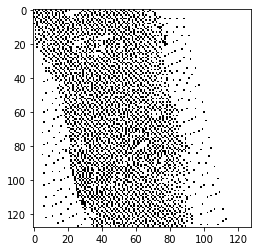

In [13]:
plt.imshow(read_file_bw(example[10]))

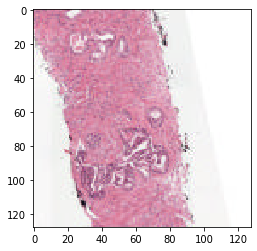

In [14]:
plt.imshow(read_file(example[10]))

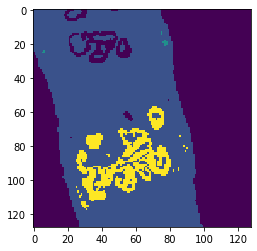

In [15]:
plt.imshow(read_mask(example[10]))

In [16]:
X = labels['image_id'].values
y = labels['isup_grade'].values

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(8412,)

In [19]:
y_train.shape

(8412,)

In [20]:
files = []
masks = []
labels = []
for i in range(len(X)):
    files.append(np.concatenate(np.array([read_file(X[i] + '_' + str(j) + '.png') 
                  for j in range(16)])))

    masks.append(np.concatenate(np.array([read_mask(X[i] + '_' + str(j) + '.png') 
              for j in range(16)])))
    
    labels.append(y[i])


In [24]:
sums = []
for m in masks:
    sums.append(m.sum())

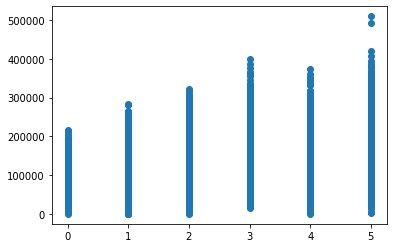

In [28]:
plt.scatter(labels, sums)

In [ ]:
files = []
masks = []
grades = []
for i in range(len(X_train)):
    files.append(np.concatenate(np.array([read_file(X[i] + '_' + str(j) + '.png') 
                  for j in range(16)])))
    
    grades.append(y[i])
    
    masks.append(np.concatenate(np.array([read_mask(X[i] + '_' + str(j) + '.png') 
                  for j in range(16)])))

# Baseline Model

In [33]:
class PANDADataset(Dataset):
    def __init__(self, X, y):
        files = []
        for i in range(len(X)):
            files.append(np.concatenate(np.array([read_file(X[i] + '_' + str(j) + '.png') 
                          for j in range(16)])))

        self.x = files
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_ds = PANDADataset(X_train, y_train)
valid_ds = PANDADataset(X_val, y_val)

In [23]:
np.concatenate(np.array([read_file('ffe9bcababc858e04840669e788065a1' + '_' + str(i) + '.png') 
                          for i in range(16)])).shape

(2048, 128, 3)

In [24]:
x, y = next(iter(train_ds))
x.shape

(2048, 128, 3)

In [25]:
xx = np.rollaxis(x, 2)
xx.shape

(3, 2048, 128)

In [26]:
X = torch.Tensor(xx)
X.shape

torch.Size([3, 2048, 128])

In [27]:
X = X.unsqueeze(0)
X.shape

torch.Size([1, 3, 2048, 128])

In [28]:
conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1)
x = conv1(X)
x.shape

torch.Size([1, 24, 2046, 126])

In [29]:
pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
x = pool1(x)
x.shape

torch.Size([1, 24, 1023, 63])

In [30]:
conv2 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1)
x = conv2(x)
x.shape

torch.Size([1, 32, 1021, 61])

In [31]:
pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
x = pool2(x)
x.shape

torch.Size([1, 32, 510, 30])

In [32]:
32 * 510 * 30

489600

In [34]:
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=5)

In [42]:
class PANDACNN(nn.Module):
    
    def __init__(self):
        super(PANDACNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(227584, 6)
        
    def forward(self, x):
        x = x.cpu().numpy()
        x = np.rollaxis(x, 3, 1)
        x = torch.Tensor(x).cuda().float()
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        return x

In [43]:
# scale of 0 (completely random) to 1 (perfect)
def quadratic_weighted_kappa(out, y):
    pass

In [44]:
def valid_metrics(model):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        x = x.long().cuda()
        y = y.long().cuda()
        batch = y.shape[0]
        out = model(x)
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = torch.argmax(out, axis=1).float()
        correct += (pred == y).float().sum().item()
    val_loss = sum_loss/total
    val_acc = correct/total
    return val_loss, val_acc

In [45]:
def train_epocs(model, optimizer, epochs=10):
    for i in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for x, y in train_dl:
            x = x.long().cuda()
            y = y.long().cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += x.size(0)*loss.item()
            total += x.size(0)
        train_loss = total_loss/total
        val_loss, val_accuracy = valid_metrics(model)
        
        print("train_loss %.3f val_loss %.3f val_accuracy %.3f" % (
            train_loss, val_loss, val_accuracy))

In [46]:
model = PANDACNN().cuda()

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_epocs(model, optimizer, epochs=5)

train_loss 15.691 val_loss 7.235 val_accuracy 0.196
train_loss 10.060 val_loss 8.834 val_accuracy 0.281
train_loss 10.132 val_loss 10.294 val_accuracy 0.217
train_loss 9.880 val_loss 11.032 val_accuracy 0.250
train_loss 7.976 val_loss 3.679 val_accuracy 0.264


In [115]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [116]:
update_optimizer(optimizer, lr=0.001)
train_epocs(model, optimizer, epochs=5)

train_loss 60146.442 val_loss 98713.561 val_accuracy 0.197
train_loss 61405.197 val_loss 58045.138 val_accuracy 0.194
train_loss 54701.367 val_loss 43148.191 val_accuracy 0.205
train_loss 56664.177 val_loss 110078.150 val_accuracy 0.128
train_loss 55973.637 val_loss 71562.544 val_accuracy 0.277


In [117]:
torch.save(model, '../models/baseline.dat')